In [1]:
from sail_safe_functions_test.helper_sail_safe_functions.generator_one_sample_float import GeneratorOneSampleFloat
from sail_safe_functions_test.helper_sail_safe_functions.generator_two_sample_float import GeneratorTwoSampleFloat
from sail_safe_functions_test.helper_sail_safe_functions.series_federated_local import SeriesFederatedLocal
from sail_safe_functions_orchestrator.statistics.estimator_reference import EstimatorReference


import plotly.graph_objects as go
import numpy
import pandas

#
from sail_safe_functions_orchestrator.statistics.min_max_federate import MinMaxFederate
from sail_safe_functions_orchestrator.statistics.kolmogorov_smirnov_test_federate import KolmogorovSmirnovTestFederate
from sail_safe_functions_orchestrator.statistics.mean_federate import MeanFederate
from sail_safe_functions_orchestrator.statistics.kurtosis_federate import KurtosisFederate

# import tests
from sail_safe_functions_orchestrator.statistics.paired_t_test_federate import PairedTTestFederate




In [2]:
alternative = "two-sided"
one_sample_normal_high_res = GeneratorOneSampleFloat("normal unit", type_distribution="normal",  mean=0.0, standard_deviation=1.0, list_weight_federation=[1.0], resolution=-1)
one_sample_normal_low_res = GeneratorOneSampleFloat("normal unit", type_distribution="normal",  mean=0.0, standard_deviation=1.0, list_weight_federation=[1.0], resolution=0.2)
one_sample_uniform_high_res = GeneratorOneSampleFloat("uniform unit", type_distribution="uniform", mean=0.0, standard_deviation=1.0, list_weight_federation=[1.0], resolution=-1)
one_sample_uniform_low_res = GeneratorOneSampleFloat("uniform unit", type_distribution="uniform", mean=0.0, standard_deviation=1.0, list_weight_federation=[1.0], resolution=0.2)

two_sample_normal_high_res = GeneratorTwoSampleFloat("normal unit", type_distribution="normal",  mean=0.0, standard_deviation=1.0, list_weight_federation=[1.0], resolution=-1)
two_sample_normal_low_res = GeneratorTwoSampleFloat("normal unit", type_distribution="normal",  mean=0.0, standard_deviation=1.0, list_weight_federation=[1.0], resolution=0.2)
two_sample_uniform_high_res = GeneratorTwoSampleFloat("uniform unit", type_distribution="uniform", mean=0.0, standard_deviation=1.0, list_weight_federation=[1.0], resolution=-1)
two_sample_uniform_low_res = GeneratorTwoSampleFloat("uniform unit", type_distribution="uniform", mean=0.0, standard_deviation=1.0, list_weight_federation=[1.0], resolution=0.2)


In [21]:
def compute_privacy(estimator, sample):
    estimate_full = numpy.array(estimator.run(sample))
    error_abs_max = numpy.zeros(estimate_full.shape)
    for i in range(sample.size):
        sample_single_knockout = sample.drop_by_index(i)
        
        estimate_single_knockout = numpy.array(estimator.run(sample_single_knockout))
        error_abs = numpy.abs(estimate_full - estimate_single_knockout)
        error_abs_max = numpy.maximum(error_abs_max, error_abs)
    return error_abs_max
    
def evaluate_accuracy(estimator, generator, list_sample_size, count_run_bias_variance, count_run_privacy):
    estimator_reference = EstimatorReference(estimator)
    # accuracy
    # bias
    count_estimate = len(estimator.list_name_estimate)
    report = {}
    report["list_size_sample"] = list_sample_size
    report["list_name_estimate"] = estimator.list_name_estimate
    report["count_run_bias_variance"] = count_run_bias_variance
    report["count_run_privacy"] = count_run_privacy
    report["dict_estimate"] = {}
    for name_estimate in estimator.list_name_estimate:
        report["dict_estimate"][name_estimate] = {}
        report["dict_estimate"][name_estimate]["list_error_mean"] = []
        report["dict_estimate"][name_estimate]["list_variance"] = []
        report["dict_estimate"][name_estimate]["list_privacy_estimator_mean"] = []
        report["dict_estimate"][name_estimate]["list_privacy_reference_mean"] = []
    for sample_size in list_sample_size:
        array_error = numpy.zeros((count_run_bias_variance, count_estimate))
        for index_run in range(count_run_bias_variance):
            sample = generator.generate(sample_size)
            array_error[index_run,:] = numpy.array(estimator_reference.run(sample)) - numpy.array(estimator.run(sample))
        for i, name_estimate in enumerate(estimator.list_name_estimate):
            error_mean = numpy.mean(array_error[:,i])
            variance = numpy.var(array_error[:,i], ddof=1)
            report["dict_estimate"][name_estimate]["list_error_mean"].append(error_mean)
            report["dict_estimate"][name_estimate]["list_variance"].append(variance)
            
    for sample_size in list_sample_size:
        array_estimator = numpy.zeros((count_run_privacy, count_estimate))
        array_reference = numpy.zeros((count_run_privacy, count_estimate))
        for index_run in range(count_run_privacy):
            sample = generator.generate(sample_size)
            array_estimator[index_run,:] = compute_privacy(estimator, sample)
            array_reference[index_run,:] = compute_privacy(estimator_reference, sample) #TODO set reference
            
        for i, name_estimate in enumerate(estimator.list_name_estimate):
            privacy_estimator = numpy.mean(array_estimator[:,i])
            privacy_reference = numpy.mean(array_reference[:,i])
            report["dict_estimate"][name_estimate]["list_privacy_estimator_mean"].append(privacy_estimator)
            report["dict_estimate"][name_estimate]["list_privacy_reference_mean"].append(privacy_reference)

    return report



estimator_ks = KolmogorovSmirnovTestFederate("normalunit", "cdf")
estimator_min_max = MinMaxFederate()
estimator_mean = MeanFederate()
estimator_kurtosis = KurtosisFederate()


list_sample_size = [5, 10, 15, 20, 25, 50, 100]
report_min_max = evaluate_accuracy(estimator_min_max, one_sample_normal_high_res, list_sample_size, 500, 50 )
report_mean = evaluate_accuracy(estimator_mean, one_sample_normal_high_res, list_sample_size, 500, 50 )
report_kurtosis = evaluate_accuracy(estimator_kurtosis, one_sample_normal_high_res, list_sample_size, 500, 50 )
report_ks = evaluate_accuracy(estimator_ks, one_sample_normal_high_res, list_sample_size, 500, 50 )


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import interpolate


def plot_estimator_summary_go(report, name_estimate):
    # for the executive summary we compute our stats at the sample_size=10 level and normalize them according to the underlining distribution (sd=1)
    accuracy_10  = abs(interpolate.interp1d(report["list_size_sample"], report["dict_estimate"][name_estimate]["list_error_mean"])(10))
    efficiency_10 = numpy.sqrt(interpolate.interp1d(report["list_size_sample"], report["dict_estimate"][name_estimate]["list_variance"])(10))
    privacy_10_e = interpolate.interp1d(report["list_size_sample"], report["dict_estimate"][name_estimate]["list_privacy_estimator_mean"])(10)
    privacy_10_r = interpolate.interp1d(report["list_size_sample"], report["dict_estimate"][name_estimate]["list_privacy_reference_mean"])(10)


    #normalize measures 
    #note that test distrbution are asumeted to 1=sd #TODO check this

    # for accuracy 1 is no bias, 0 is 10^0.5 sd bias (50% outside side the 95% range )
    #TODO relate this to cramer rao
    accuracy =  1 - (accuracy_10 * numpy.sqrt(10))

    # for efficenty 1 is no variance, and 0 is 10^0.5 sd bias (spread larger than that of distribution)
    #TODO make this relate to cramer rao lower bound
    efficiency = 1 - (efficiency_10 * numpy.sqrt(10))

    # for privacy 1 is no knockout difference, and 0 is 2 time reference difference
    #TODO relate this to kl divergence
    privacy = 1 - (privacy_10_e / (privacy_10_r * 2))

    #clamp measures
    accuracy = max(0, min(1, accuracy))
    efficiency = max(0, min(1, efficiency))
    privacy = max(0, min(1, privacy))

    return go.Scatterpolar(
            name=name_estimate,
            r=[accuracy, efficiency, privacy], 
            theta=["accuracy", "effciency", "privacy"],
            fill="toself")
        
def plot_estimator_comparrison(list_tuple_report):
    list_go = []
    for report, name_estimate in list_tuple_report:
        list_go.append(plot_estimator_summary_go(report, name_estimate))
        
    fig = go.Figure(data=list_go)
        

    fig.update_layout(
        height=400, 
        width=400, 
        title_text=f"Comparison", 
        polar=dict(
            radialaxis=dict(
              visible=True,
              range=[0, 1]
            )),
        showlegend=True)
    fig.show()

        
def plot_report_estimator(title, report):

  
    for name_estimate in report["list_name_estimate"]:
        list_subplot_title = []
        list_subplot_title.append(f"\"{name_estimate}\" bias")
        list_subplot_title.append(f"\"{name_estimate}\" efficiency / quality")
        list_subplot_title.append(f"\"{name_estimate}\" suffcientcy / privacy")

        fig = make_subplots(
            rows=1, 
            cols=3,
            subplot_titles=list_subplot_title)

        go_bias = go.Scatter(
            x=report["list_size_sample"], 
            y=report["dict_estimate"][name_estimate]["list_error_mean"],
            line=dict(color="#0000ff"))
        go_sd = go.Scatter(
            x=report["list_size_sample"], 
            y=report["dict_estimate"][name_estimate]["list_variance"],
            line=dict(color="#0000ff"))
        go_privacy_estimator = go.Scatter(
            x=report["list_size_sample"], 
            y=report["dict_estimate"][name_estimate]["list_privacy_estimator_mean"],
            line=dict(color="#0000ff"))

        go_privacy_reference = go.Scatter(
            x=report["list_size_sample"], 
            y=report["dict_estimate"][name_estimate]["list_privacy_reference_mean"],
            line=dict(color="#ff0000"))

        fig.add_trace(go_bias, row=1,col=1)
        fig.add_trace(go_sd, row=1, col=2)        
        fig.add_trace(go_privacy_estimator, row=1, col=3)
        fig.add_trace(go_privacy_reference, row=1, col=3)

        fig["layout"]["xaxis"]["title"]="sample size"
        fig["layout"][f"xaxis2"]["title"]="sample size"
        fig["layout"][f"xaxis3"]["title"]="sample size"

        fig.update_layout(height=350, width=800, title_text="Quality report for " + title, showlegend=False)
        fig.show()
        
        
        fig = go.Figure(data=plot_estimator_summary_go(report, name_estimate))
        

        fig.update_layout(
            height=400, 
            width=400, 
            title_text=f"Summary for {name_estimate}", 
            polar=dict(
                radialaxis=dict(
                  visible=True,
                  range=[0, 1]
                )),
            showlegend=False)
        fig.show()

plot_report_estimator("MinMax with normal distribution", report_min_max)
plot_report_estimator("Mean with normal distribution", report_mean)
plot_report_estimator("Kurtosis with normal distribution", report_kurtosis)
plot_report_estimator("KolmogorovSmirnov with normal distribution", report_ks)






In [ ]:
plot_estimator_comparrison([(report_min_max, "min"), (report_min_max, "max"), (report_ks, "k_statistic"), (report_mean, "mean"), (report_kurtosis, "kurtosis")])




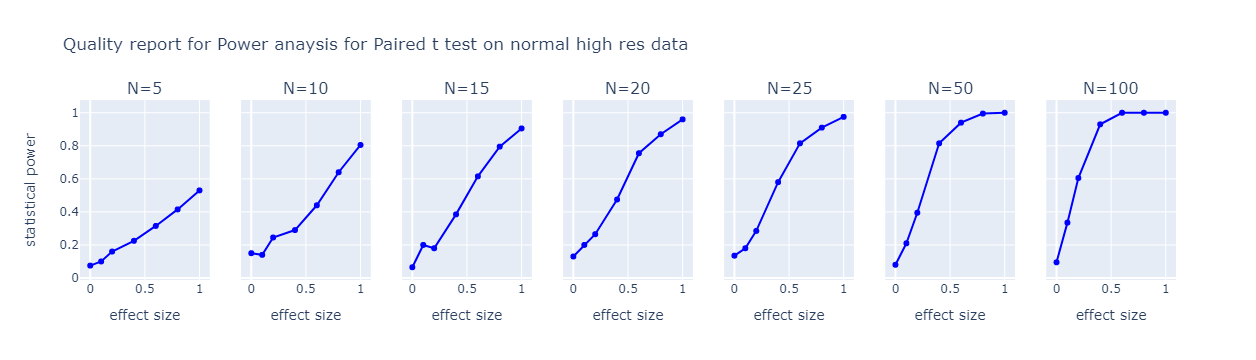

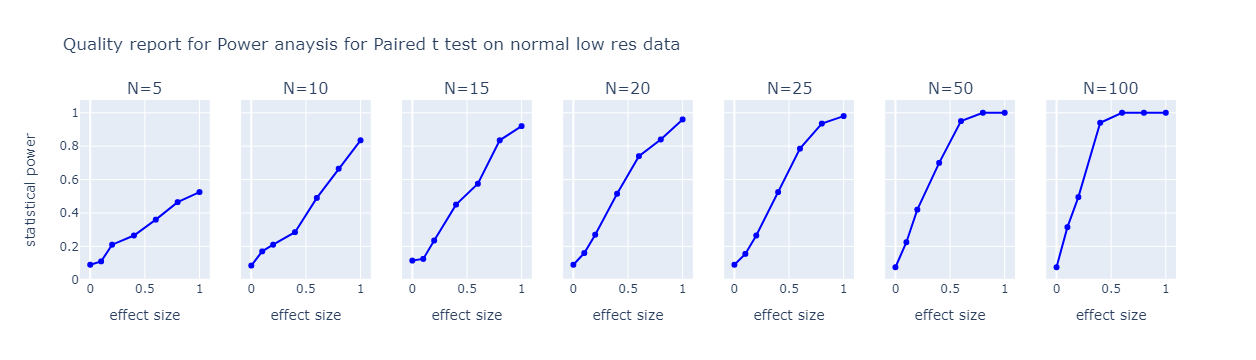

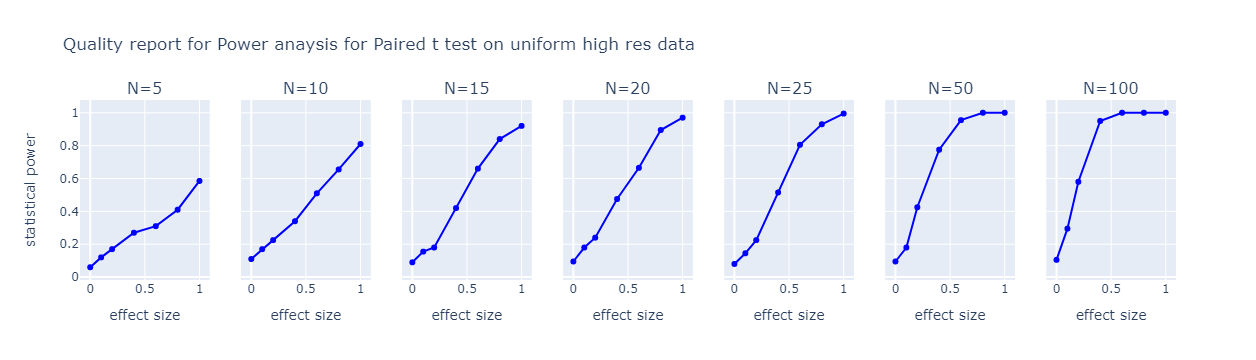

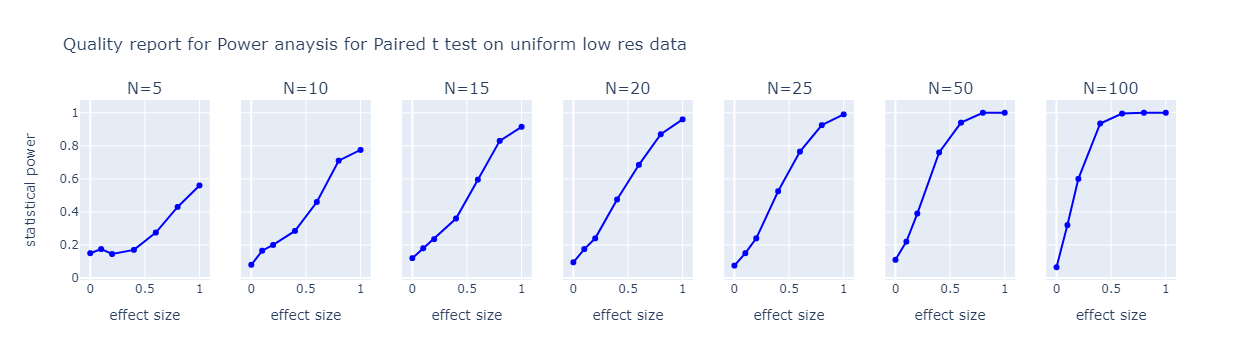

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import interpolate

def create_report_power(estimator_test, generator, list_sample_size, list_effect_size, is_paired:bool=False, significance=0.05, run_count=100):
    count_hit = 0
    report = {}
    report["list_sample_size"] = list_sample_size
    report["list_effect_size"] = list_effect_size
    report["list_list_fraction_hit"] = []
    for sample_size in list_sample_size:
        list_fraction_hit = []
        for effect_size in list_effect_size:
            hit_count = 0
            for _ in range(run_count):
                sample_0, sample_1 = generator.generate(sample_size, effect_size, is_paired)
                t, p = estimator_test.run(sample_0, sample_1)
                if p < significance:
                    hit_count += 1
            list_fraction_hit.append(hit_count/run_count)
            
        report["list_list_fraction_hit"].append(list_fraction_hit)
    return report

def plot_report_power(report_power, title):
    list_subplot_titles = []
    for sample_size in report_power["list_sample_size"]:
        list_subplot_titles.append(f"N={sample_size}")


    fig = make_subplots(
        rows=1, 
        cols=len(list_sample_size),
        shared_yaxes=True,
        subplot_titles=list_subplot_titles)

    for i, sample_size in enumerate(report_power["list_sample_size"]):
        go_bias = go.Scatter(
            x=report_power["list_effect_size"], 
            y=report_power["list_list_fraction_hit"][i],
            line=dict(color="#0000ff"))
        fig.add_trace(go_bias, row=1,col=i+1)
    
    fig["layout"]["yaxis"]["title"]="statistical power"
    fig["layout"]["xaxis"]["title"]="effect size"
    for  i in range(len(report_power["list_sample_size"]) - 1):
        fig["layout"][f"xaxis{i+2}"]["title"]="effect size"
    
    fig.update_layout(height=350, width=1200, title_text="Quality report for " + title, showlegend=False)
    fig.show()

list_sample_size:[5, 10, 15, 25, 50]
list_effect_size=[0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
is_paired=False
significance = 0.05
run_count = 200


from sail_safe_functions_orchestrator.statistics.paired_t_test_federate import PairedTTestFederate


#two_sample_normal_high_res 
#two_sample_normal_low_res
#two_sample_uniform_high_res
#two_sample_uniform_low_res


estimator = PairedTTestFederate(alternative="two-sided")
report_power = create_report_power(estimator, two_sample_normal_high_res, list_sample_size, list_effect_size, is_paired, significance, run_count)
plot_report_power(report_power, "Power anaysis for Paired t test on normal high res data")
report_power = create_report_power(estimator, two_sample_normal_low_res, list_sample_size, list_effect_size, is_paired, significance, run_count)
plot_report_power(report_power, "Power anaysis for Paired t test on normal low res data")
report_power = create_report_power(estimator, two_sample_uniform_high_res, list_sample_size, list_effect_size, is_paired, significance, run_count)
plot_report_power(report_power, "Power anaysis for Paired t test on uniform high res data")
report_power = create_report_power(estimator, two_sample_uniform_low_res, list_sample_size, list_effect_size, is_paired, significance, run_count)
plot_report_power(report_power, "Power anaysis for Paired t test on uniform low res data")




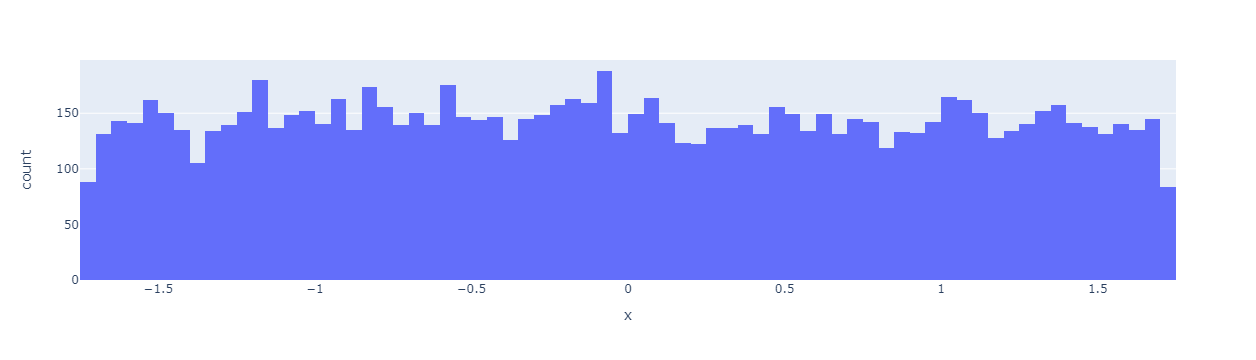

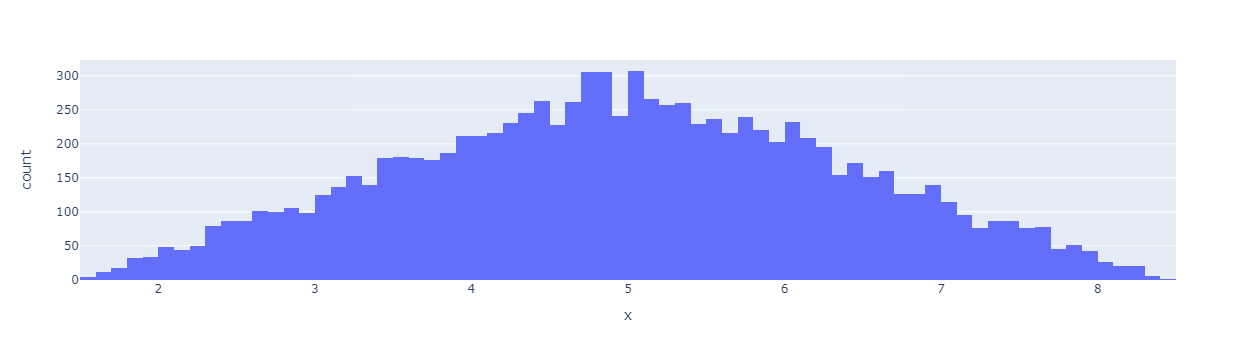

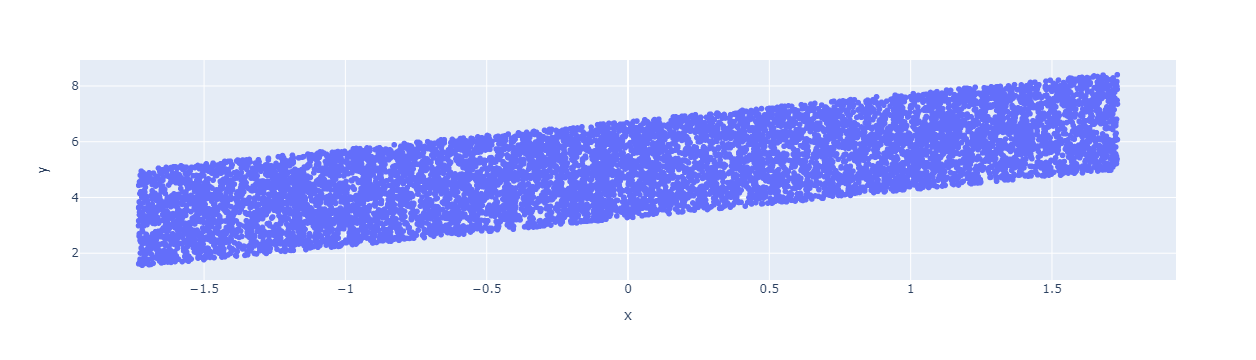

In [23]:
s1, s2 = two_sample_uniform_high_res.generate(10000, 5, True)

import plotly.express as px
fig = px.histogram(x=s1.to_numpy())
fig.show()

fig = px.histogram(x=s2.to_numpy())
fig.show()

fig = px.scatter(x=s1.to_numpy(), y=s2.to_numpy())
fig.show()